In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
import pandas as pd
from glob import glob
import os


In [21]:
# !ls "results_sims/sims"

In [30]:
LR = 0.001
data_path = "results_sims_steps/sims"

In [31]:
class CombinedArrayDataset(Dataset):
    def __init__(self, folder_path):
        # Load all CSV files in the folder
        csv_files = glob(os.path.join(folder_path, "*.csv"))
        data_frames = [pd.read_csv(file) for file in csv_files]
        combined_df = pd.concat(data_frames, ignore_index=True)

        # Parse the arrays and labels
        self.belief = combined_df['belief'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.ship = combined_df['ship'].apply(lambda x: np.array(eval(x), dtype=np.float32)).tolist()
        self.labels = combined_df['remain'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the array and label for the given index
        belief = self.belief[idx]
        ship = self.ship[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        belief = torch.tensor(belief, dtype=torch.float32)  # Ensure float32 for features
        ship = torch.tensor(ship, dtype= torch.float32)
        label = torch.tensor(label, dtype=torch.float32)  # Ensure long for labels

        # Combine belief and ship as two channels
        input_tensor = torch.stack((belief, ship), dim=0)  # Shape: (2, height, width)
        return input_tensor, label

# Example usage

dataset = CombinedArrayDataset(data_path)


In [32]:
len(dataset)

89842

In [ ]:
class SpaceRatNetwork(nn.Module):
    def __init__(self):
        super(SpaceRatNetwork, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(2, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            d
        )
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(30*30, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x 
        

In [34]:
# dataset = CustomDataset(data_path)

# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
model = SpaceRatNetwork()
loss_funtion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [36]:
model.train()
train_losses = []
test_losses = []

In [37]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute the loss
        loss = loss_funtion(outputs.squeeze(), targets)
        train_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Testing Loop
    model.eval()
    test_loss = 0.0
    with torch.no_grad():  # No need to compute gradients during testing
        for inputs, targets in test_loader:
            # Forward pass
            outputs = model(inputs)
            
            # Compute the loss
            loss = loss_funtion(outputs.squeeze(), targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Test Loss: {avg_test_loss:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1800 and 900x256)

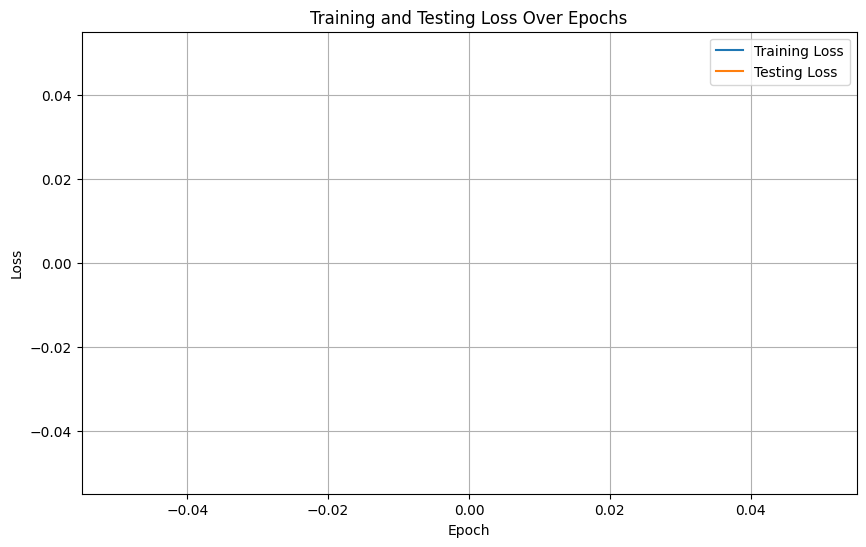

In [19]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

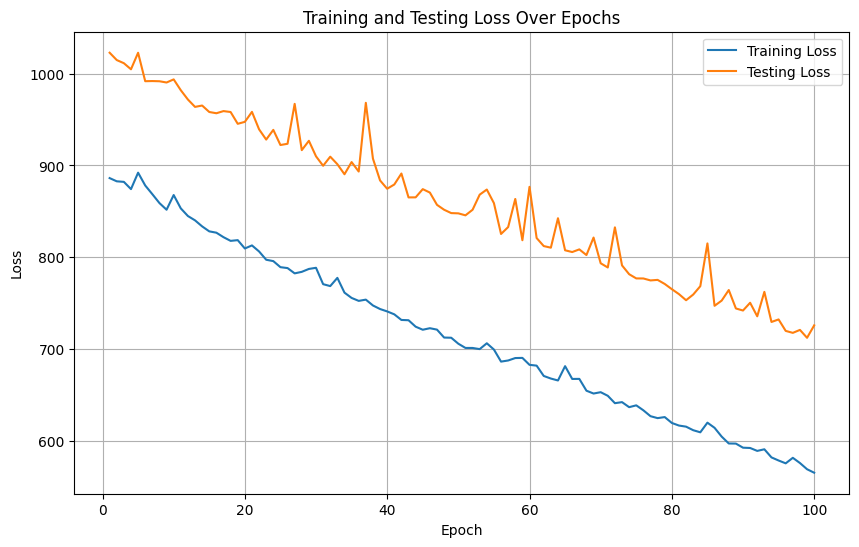

In [48]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

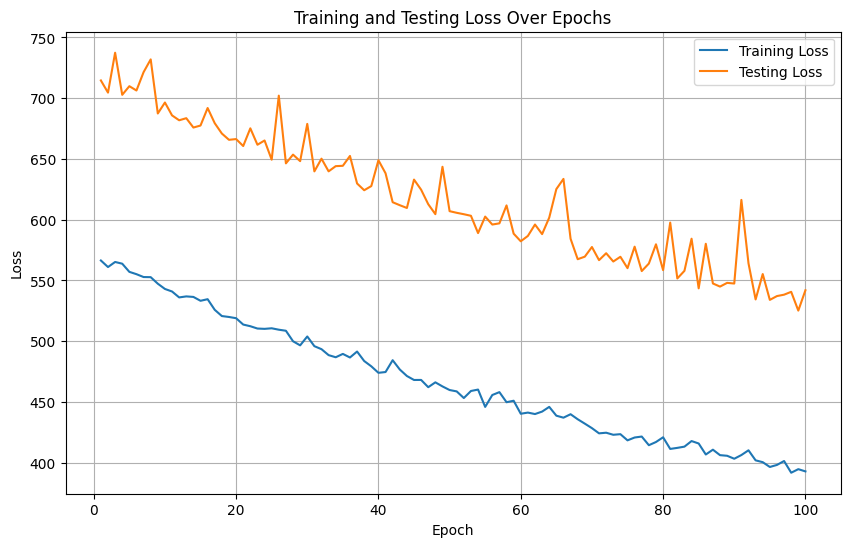

In [50]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [66]:
test_iter = iter(test_loader)


In [67]:
array, label = next(test_iter)
array.shape, label

(torch.Size([2, 30, 30]), tensor([24., 23.]))